# Alternative Orbital Interaction Scenarios of the MW-M31 System.

For my project, I worked with the code developed in Lab 11. Since Lab 11 did not incorporate the tangential velocity, the code had to be manipulated so that it could work with the tangential velocity values. 

1. First step was to extract radial velocity and tangential velocity values from the galactocentric velocity values (discussed in my paper). The radial velocity was found by projecting the velocity values on the relative distance vector:
\begin{equation}
proj_{\vec{r}}\vec{v} = (\vec{v}\cdot\vec{r}) \frac{\vec{r}}{r^2} \\
\end{equation}

2. The tangential velocity vector can be found just by subtracting radial velocity from the galactocentric velocity.

3. The galactocentric velocity values needs to be randomized (so that we don't have to physically change the values of velocity in every run). 

NOTE: The other functions in this class are described in my final paper under the Methodology section. The velocity values used are tabulated in the paper.

In [3]:
# import necessary modules
# numpy provides powerful multi-dimensional arrays to hold and manipulate data
import numpy as np
# matplotlib provides powerful functions for plotting figures
import matplotlib.pyplot as plt
# astropy provides unit system and constants for astronomical calculations
import astropy.units as u
import astropy.constants as const
# import Latex module so we can display the results with symbols
from IPython.display import Latex
%matplotlib inline

# import the CenterOfMass to determine the COM pos/vel of M31
from CenterOfMass2 import CenterOfMass
# import the GalaxyMass to determine the mass of M31 and MW for each component
from GalaxyMass import ComponentMass
import random

In [10]:
class MWAnalyticOrbit:
    """ Calculate the analytical orbit of MW-M31 system """
    
    def __init__(self, filename):
        """ Initialize the class with the current properties of MW and M31 
        input: filename, string denoting the name of the file in which the output orbit will be stored """
        
        # get the gravitational constant (the value is 4.498502151575286e-06)
        self.G = const.G.to(u.kpc**3/u.Msun/u.Gyr**2).value
        
        # store the output file name
        self.filename = filename
        
        # get the current pos/vel of MW 
        MW_COM = CenterOfMass("MW_000.txt", 2)
        
        self.r0 = MW_COM.COM_P(0.1, 2)  # equivalently could have set self.x self.y self.z to each component.
        
        self.v0 = MW_COM.COM_V(self.r0[0], self.r0[1],self.r0[2]).value
       
        self.r0 = self.r0.value
      
        
        M31_COM = CenterOfMass("M31_000.txt", 2)
        M31_r0 = M31_COM.COM_P(0.1, 2)
        
        ############# Add velocity calculations here:
         
        # Values taken from Van der Marel et al. (2019). 
        # Randomly chooses a number within the given range of values
        vx = random.randint(-2,70)
        vy = random.randint(-148,-98)
        vz = random.randint(-56,18)
        
        # v is the galactocentric velocity. 
        v = np.array([vx,vy,vz]) 
        
        # Use the projection formula from vector calc:
        # 1. dot product of the distance vector and total velocity vector
        # 2. to find the projection of v on r: (v.r)*r/r_mag^2
        
        v_r = np.dot(v,self.r0)*self.r0/np.linalg.norm(self.r0)**2
        vr_mag = np.linalg.norm(v_r)
        
        v_tan = v - v_r # v = v_r + vtan
        vtan_mag = np.linalg.norm(v_tan) #np.sqrt(v_tan[0]**2+v_tan[1]**2+v_tan[2]**2)
        print(v_r)
        print(v_tan)
        print(v)
        print('Total velocity magnitude is %f'%np.sqrt(vr_mag**2+vtan_mag**2))
        
        ########## Checkpoint ##############
        # To check whether our calculations are right, compare the previous answer
        # to the magnitude of the galactocentric velocity.
        
        #print('Magnitude of galactocentric velocity is %f'%np.linalg.norm(v))
        
        # when tangential velocity = 0, I take the currently defined values of velocity from 
        # M31_000.txt file.
        
        #M31_v0 = M31_COM.COM_V(M31_r0[0], M31_r0[1], M31_r0[2]).value
        #print(np.linalg.norm(M31_v0))
        
        self.r0 -= M31_r0.value  # subtract out the M31 COM Position from the previously defined values
        self.v0 -= v # subtract out the M31 COM velocity from the previously defined values
        
        
        
        #### get the mass of each component in M31 and MW 
        # disk
        self.rdisk = 5.0 # set the scale length 
        self.Mdisk = ComponentMass("M31_000.txt", 2)*1e12
        self.MWdisk = ComponentMass('MW_000.txt',2)*1e12
        
        # bulge
        self.rbulge = 1.0 # set the bulge scale length
        self.Mbulge = ComponentMass("M31_000.txt", 3)*1e12
        self.MWbulge = ComponentMass('MW_000.txt',3)*1e12
        
        # Halo
        self.rhalo = 61.58 # use the Hernquist scale length (a) computed in HW5
        self.Mhalo = ComponentMass("M31_000.txt", 1)*1e12
        self.MWhalo = ComponentMass('MW_000.txt',1)*1e12
       
    
        ### ADD MW TOTAL MASS HERE #### 
        self.MWmass = self.MWdisk + self.MWbulge + self.MWhalo
        self.M31mass = self.Mdisk + self.Mbulge + self.Mhalo
    
        ### ADD M31 CIRCULAR SPEED HERE ### 
        self.Vc = 230 #km/s
        
        ### Fudge factor ## 
        self.fudge = 0.1
    
    
    def HenquistAccel(self, M, r_a, r):
        """ Compute the Hernquist profile acceleration 
        Inputs :  M the Hernquist mass (Msun)
                r_a the Hernquist scale length (kpc)
                r the position vector [ x, y, z]
        Returns:  the Acceleration vector for a Hernquist profile [Ax, Ay, Az]"""
        
        # follow the formula in the paper
        r_mag = np.sqrt(np.sum(r**2))
        epsilon = 1e-3 # a softening factor
        return -self.G * M / ((r_mag+epsilon) * (r_a + r_mag)**2) * r
    
    def MiyamotoNagaiAccel(self, M, rd, r):
        """ Compute the Miyamoto-Nagai profile acceleration
        Inputs:  M  the disk mass (Msun)
                rd the disk scale length (kpc)
                r the position vector [ x, y, z]
        Returns: the Acceleration vector for a Miyamoto-Nagai profile [Ax, Ay, Az] """
        
        # follow the formula in the HW instructions
        R2 = np.sum(r[:2]**2)
        zd = rd / 5.0
        B = rd + np.sqrt(r[2]**2 + zd**2)
        return -self.G * M / (R2 + B**2)**1.5 * r * np.array([1, 1, B/(B-rd)]) 
        # the np.array allows for a different value for the z component of the acceleration
  

    def DynamicalFriction(self,M,Vc,r,v):
        '''Function that computes dynamical friction on M31 galaxy.
        INPUTS: M = Mass of galaxy (in Msun); Vc = circular speed at large radii from M31.
        r = position vector of M31.
        v = veloctiy vector of M31.
        RETURNS: deceleration vector due to dynamical friction.
        a = 0.428 G M ln(lambda) /rmag^2 v/vmag'''
        rmag = np.sqrt(r[0]**2+r[1]**2+r[2]**2)
        vmag = np.sqrt(v[0]**2+v[1]**2+v[2]**2)
        # defining terms in Coulomb logarithm: ln(Lambda)
        bmax = rmag
        bmin = self.G*M/Vc**2
        Coulomb = np.log(bmax/bmin)
        
        return -0.428*self.G*M*Coulomb/rmag**2*v/vmag*self.fudge
    
    
        
    ##### ADD v to M31Accel input #### 
    def M31Accel(self,r,v):
        """ Compute the total acceleration from M31
        Input: r the position vector [ x, y, z]
               v the velocity vector[vx,vy,vz]
        Returns: A vector for the total acceleration (halo+ bulge+ disk) [ Ax, Ay, Az]"""
        
        ###### ADD DYNAMICAL FRICTION HERE
        return self.HenquistAccel(self.Mhalo, self.rhalo, r) \
             + self.HenquistAccel(self.Mbulge, self.rbulge, r) \
             + self.MiyamotoNagaiAccel(self.Mdisk, self.rdisk, r) \
             + self.DynamicalFriction(self.MWhalo,self.Vc,r,v) 
    
    
    def LeapFrog(self, dt, r, v):
        """ perform one step Leap Frog integration for M33
        Input: dt time step in Gyr
            r the current position vector [ x, y, z] 
            v the currentvelocity vector [ vx, vy, vz]
        Returns:  Advances the position and velocity vectors by one timestep """
        
        # predict the position at the next half timestep
        rhalf = r + v * dt / 2.0
        
        # compute the velocity at the next timestep
        ##### ADD v to M31Accel ### 
        vnext = v + self.M31Accel(rhalf,v) * dt
        
        # compute the position at the next timestep
        rnext = r + (vnext+v)/2.0 * dt 
        
        return rnext, vnext
    
    def OrbitIntegration(self, t0, dt, tmax):
        """ Compute the orbit of M33 using the LeapFrog Scheme
        Input:  t0 the current time in Gyr
                dt the time step in Gyr
                tmax the final time in Gyr
        Returns: Generates a file with the original filename given when the class was initialized that stores
                the output of the orbit."""
        
        # initialize the time, counter, and the orbit array
        t = t0
        i = 1
        orbit = np.zeros([int(tmax/dt)+2, 7])
        
        orbit[0] = t0, *tuple(self.r0), *tuple(self.v0)
        
        # start the integration
        while (t < tmax):
            # move forward the time by one timestep
            t += dt
            orbit[i, 0] = t
            # integrate the position and velocity using the LeapFrog scheme
            orbit[i, 1:4], orbit[i, 4:] = \
                self.LeapFrog(dt, orbit[i-1, 1:4], orbit[i-1, 4:])
            
            i += 1 # update counter
        
        # write the data to a file
        np.savetxt(self.filename, orbit, fmt = "%11.3f"*7, comments='#', 
                   header="{:>10s}{:>11s}{:>11s}{:>11s}{:>11s}{:>11s}{:>11s}"\
                   .format('t', 'x', 'y', 'z', 'vx', 'vy', 'vz'))
        

In [18]:
# Instantiating classes for different values of galactocentric velocity.
MW = MWAnalyticOrbit("MWAnalyticOrbit.txt")
MW.OrbitIntegration(0, 0.1, 10.)

[ 54.51310479 -77.68775804  38.18550819]
[-22.51310479 -49.31224196 -68.18550819]
[  32 -127  -30]
Total velocity magnitude is 134.361453
Magnitude of galactocentric velocity is 134.361453


In [16]:
MW2 = MWAnalyticOrbit("MWAnalyticOrbit2.txt")
MW2.OrbitIntegration(0,0.1,10.)

[  72.41481388 -103.19985553   50.72535272]
[-20.41481388 -36.80014447 -45.72535272]
[  52 -140    5]
Total velocity magnitude is 149.428913
Magnitude of galactocentric velocity is 149.428913


In [20]:
MW3 = MWAnalyticOrbit("MWAnalyticOrbit3.txt")
MW3.OrbitIntegration(0,0.1,10.)

[ 56.25389168 -80.16858959  39.40489997]
[ -2.25389168 -27.83141041 -53.40489997]
[  54 -108  -14]
Total velocity magnitude is 121.556571
Magnitude of galactocentric velocity is 121.556571


In [22]:
MW4 = MWAnalyticOrbit("MWAnalyticOrbit4.txt")
MW4.OrbitIntegration(0,0.1,10.)

[ 48.00127237 -68.40761039  33.62407968]
[-37.00127237 -65.59238961 -80.62407968]
[  11 -134  -47]
Total velocity magnitude is 142.428930
Magnitude of galactocentric velocity is 142.428930


In [14]:
# Tangential velocity is zero here:
MW5 = MWAnalyticOrbit("MWAnalyticOrbit5.txt")
MW5.OrbitIntegration(0,0.1,10.) 

113.63231098591633


In [23]:
orbit_type = np.dtype([('t', 'f8'), ('r', 'f8', 3), ('v', 'f8', 3)])

# Read in Orbit of M33 relative to M31
MWOrbit = np.loadtxt("MWAnalyticOrbit.txt", dtype=orbit_type)
MWOrbit2 = np.loadtxt("MWAnalyticOrbit2.txt", dtype=orbit_type)
MWOrbit3 = np.loadtxt("MWAnalyticOrbit3.txt", dtype=orbit_type)
MWOrbit4 = np.loadtxt("MWAnalyticOrbit4.txt", dtype=orbit_type)
MWOrbit5 = np.loadtxt("MWAnalyticOrbit5.txt", dtype=orbit_type)



# Read in simulation Orbit from Homework 6
MWSimOrbit = np.genfromtxt('Orbit_MW.txt', dtype = orbit_type)
M31SimOrbit = np.genfromtxt('Orbit_M31.txt', dtype = orbit_type)

In [24]:
def relative_mag(orbit1, orbit2): # calculate relative sep or vel
    return np.sqrt(np.sum((orbit1['r'] - orbit2['r'])**2, axis=1)), \
           np.sqrt(np.sum((orbit1['v'] - orbit2['v'])**2, axis=1))
def vector_mag(orbit):
    return np.sqrt(np.sum(orbit['r']**2, axis=1)), \
           np.sqrt(np.sum(orbit['v']**2, axis=1))

In [25]:
# Determine the magnitude of the position and velocities 

# of MW and M31
M31_MW_R, M31_MW_V = vector_mag(MWOrbit)
M31_MW_R2, M31_MW_V2 = vector_mag(MWOrbit2)
M31_MW_R3, M31_MW_V3 = vector_mag(MWOrbit3)
M31_MW_R4, M31_MW_V4 = vector_mag(MWOrbit4)
M31_MW_R5, M31_MW_V5 = vector_mag(MWOrbit5)


# of MW and M31
M31_MW_SimR, M31_MW_SimV = relative_mag(M31SimOrbit, MWSimOrbit)

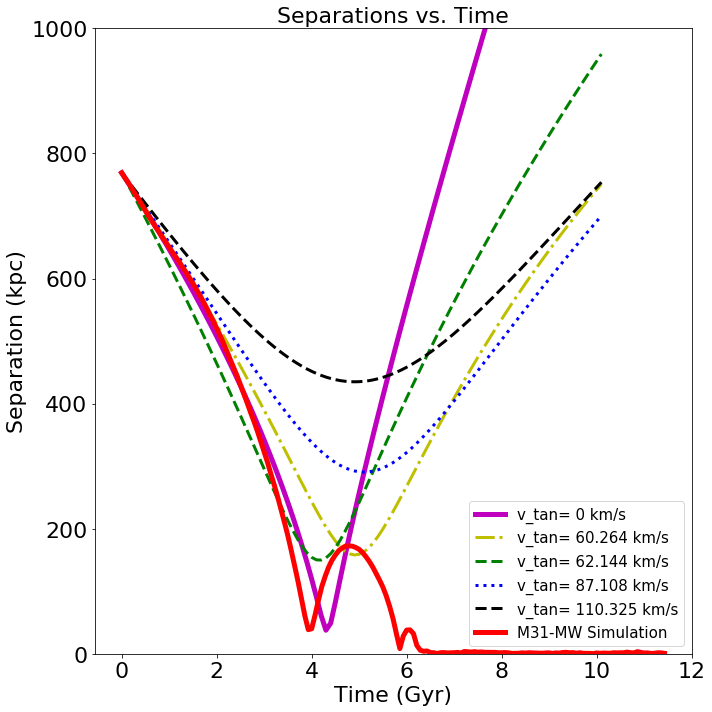

In [45]:
# Plot the orbital separations of the galaxies 
#################################

fig, ax= plt.subplots(figsize=(10, 10))

# Plot the analytical separation of M31 and M33
ax.plot(MWOrbit5['t'], M31_MW_R5, 'm', lw=5, label='v_tan= 0 km/s')
ax.plot(MWOrbit3['t'], M31_MW_R3,'y',linestyle = '-.',  lw=3, label='v_tan= 60.264 km/s')
ax.plot(MWOrbit2['t'], M31_MW_R2,'g',linestyle = '--',lw=3, label='v_tan= 62.144 km/s')
ax.plot(MWOrbit['t'], M31_MW_R, 'b',linestyle = ':',lw=3, label='v_tan= 87.108 km/s')
ax.plot(MWOrbit4['t'], M31_MW_R4,'k',linestyle = '--', lw=3, label='v_tan= 110.325 km/s')


# Plot the simulated separation of M31 and MW
ax.plot(MWSimOrbit['t'], M31_MW_SimR, 'r', lw=5, label='M31-MW Simulation')

# Add axis labels
ax.set_xlabel('Time (Gyr)', fontsize=22)
ax.set_ylabel('Separation (kpc)', fontsize=22)
ax.set_title("Separations vs. Time", fontsize=22)

#adjust tick label font size
ax.xaxis.set_tick_params(labelsize=22)
ax.yaxis.set_tick_params(labelsize=22)

# add a legend with some customizations.
legend = ax.legend(loc='best',fontsize=15)

plt.ylim(0, 1000)

# tight layout
fig.tight_layout()

# Save to a file
fig.savefig('orbit_interaction.png',dpi=125)

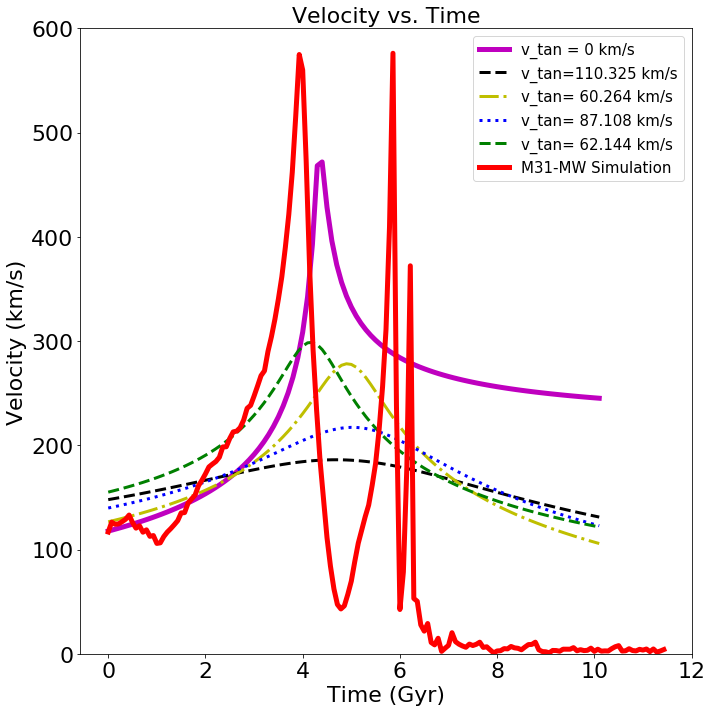

In [46]:
# Plot the orbital velocities of the galaxies 
#################################

fig, ax= plt.subplots(figsize=(10, 10))

# Plot the analytical separation of M31 and M33
ax.plot(MWOrbit5['t'], M31_MW_V5, 'm', lw=5, label='v_tan = 0 km/s')
ax.plot(MWOrbit4['t'], M31_MW_V4,'k',linestyle = '--', lw=3, label='v_tan=110.325 km/s')
ax.plot(MWOrbit3['t'], M31_MW_V3,'y',linestyle = '-.',  lw=3, label='v_tan= 60.264 km/s')
ax.plot(MWOrbit['t'], M31_MW_V, 'b',linestyle = ':',lw=3, label='v_tan= 87.108 km/s')
ax.plot(MWOrbit2['t'], M31_MW_V2,'g',linestyle = '--',lw=3, label='v_tan= 62.144 km/s')

# Plot the simulated velocity of M31-MW system
ax.plot(MWSimOrbit['t'], M31_MW_SimV, 'r', lw=5, label='M31-MW Simulation')

# Add axis labels
ax.set_xlabel('Time (Gyr)', fontsize=22)
ax.set_ylabel('Velocity (km/s)', fontsize=22)
ax.set_title("Velocity vs. Time", fontsize=22)

#adjust tick label font size
ax.xaxis.set_tick_params(labelsize=22)
ax.yaxis.set_tick_params(labelsize=22)

# add a legend with some customizations.
legend = ax.legend(loc='upper right',fontsize=15)

plt.ylim(0, 600)

# tight layout
fig.tight_layout()

# Save to a file
fig.savefig('orbit_velocties.png',dpi=125)